## Introduction

This is my first SageMaker exploration: Improve clustering accuracy by modifing K-means to MXNet.

Welcome to our first end-to-end example! Today, we're working through a classification problem, specifically of images of handwritten digits, from zero to nine. Let's imagine that this dataset doesn't have labels, so we don't know for sure what the true answer is. In later examples, we'll show the value of "ground truth", as it's commonly known.

Today, however, we need to get these digits classified without ground truth. A common method for doing this is a set of methods known as "clustering", and in particular, the method that we'll look at today is called k-means clustering. In this method, each point belongs to the cluster with the closest mean, and the data is partitioned into a number of clusters that is specified when framing the problem. In this case, since we know there are 10 clusters, and we have no labeled data (in the way we framed the problem), this is a good fit.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are two parts to this:

1. The role(s) used to give learning and hosting access to your data. Here we extract the role you created earlier for accessing your notebook.  See the documentation if you want to specify  a different role
1. The S3 bucket name and locations that you want to use for training and model data.

In [1]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='shanxingprojects'

### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training.  In this case we'll use the MNIST dataset, which contains 70K 28 x 28 pixel images of handwritten digits.  For more details, please see [here](http://yann.lecun.com/exdb/mnist/).

This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 900 ms, sys: 276 ms, total: 1.18 s
Wall time: 4.49 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

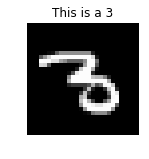

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## Training the MXNet model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. 

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 7 and 11 minutes.

In [4]:
#Bucket location to save your custom code in tar.gz format.
custom_code_upload_location = 's3://shanxingprojects/mxnet/code_output'

#Bucket location where results of model training are saved.
model_artifacts_location = 's3://shanxingprojects/model_result'

#IAM execution role that gives SageMaker access to resources in your AWS account.
#We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()
print('training data will be uploaded to: {}'.format(custom_code_upload_location))
print('training artifacts will be uploaded to: {}'.format(model_artifacts_location))

training data will be uploaded to: s3://shanxingprojects/mxnet/code_output
training artifacts will be uploaded to: s3://shanxingprojects/model_result


In [5]:
#!cat mnist.py

In [6]:
%%time
from sagemaker.mxnet import MXNet

mnist_estimator = MXNet(entry_point='mnist.py',
                        role=role,
                        output_path=model_artifacts_location,
                        code_location=custom_code_upload_location,
                        train_instance_count=1, 
                        train_instance_type='ml.m4.xlarge',
                        hyperparameters={'learning_rate': 0.1})

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 28.4 ms


In [7]:
%%time
import boto3

region = boto3.Session().region_name
train_data_location = 's3://sagemaker-sample-data-{}/mxnet/mnist/train'.format(region)
test_data_location = 's3://sagemaker-sample-data-{}/mxnet/mnist/test'.format(region)

mnist_estimator.fit({'train': train_data_location, 'test': test_data_location})

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-py2-cpu-2018-03-10-00-10-24-018


.....................................................................
executing startup script (first run)
2018-03-10 00:15:44,823 INFO - root - running container entrypoint
2018-03-10 00:15:44,823 INFO - root - starting train task
2018-03-10 00:15:46,709 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 0, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'mnist.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt

2018-03-10 00:16:08,109 INFO - root - Epoch[9] Batch [400]#011Speed: 37701.98 samples/sec#011accuracy=0.978100
2018-03-10 00:16:08,399 INFO - root - Epoch[9] Batch [500]#011Speed: 34429.21 samples/sec#011accuracy=0.978200
2018-03-10 00:16:08,702 INFO - root - Epoch[9] Train-accuracy=0.979899
2018-03-10 00:16:08,702 INFO - root - Epoch[9] Time cost=1.738
2018-03-10 00:16:08,849 INFO - root - Epoch[9] Validation-accuracy=0.968400
2018-03-10 00:16:09,104 INFO - root - Epoch[10] Batch [100]#011Speed: 39584.70 samples/sec#011accuracy=0.977822
2018-03-10 00:16:09,380 INFO - root - Epoch[10] Batch [200]#011Speed: 36281.18 samples/sec#011accuracy=0.979600
2018-03-10 00:16:09,680 INFO - root - Epoch[10] Batch [300]#011Speed: 33423.25 samples/sec#011accuracy=0.982700
2018-03-10 00:16:09,979 INFO - root - Epoch[10] Batch [400]#011Speed: 33455.00 samples/sec#011accuracy=0.980600
2018-03-10 00:16:10,240 INFO - root - Epoch[10] Batch [500]#011Speed: 38373.43 samples/sec#011accuracy=0.982300
2018-03-

2018-03-10 00:16:35,373 INFO - root - Epoch[23] Batch [300]#011Speed: 34579.22 samples/sec#011accuracy=0.997900
2018-03-10 00:16:35,712 INFO - root - Epoch[23] Batch [400]#011Speed: 29509.86 samples/sec#011accuracy=0.997500
2018-03-10 00:16:36,001 INFO - root - Epoch[23] Batch [500]#011Speed: 34600.50 samples/sec#011accuracy=0.997300
2018-03-10 00:16:36,340 INFO - root - Epoch[23] Train-accuracy=0.997879
2018-03-10 00:16:36,341 INFO - root - Epoch[23] Time cost=1.910
2018-03-10 00:16:36,479 INFO - root - Epoch[23] Validation-accuracy=0.974800
2018-03-10 00:16:36,813 INFO - root - Epoch[24] Batch [100]#011Speed: 30188.51 samples/sec#011accuracy=0.997822
2018-03-10 00:16:37,111 INFO - root - Epoch[24] Batch [200]#011Speed: 33511.51 samples/sec#011accuracy=0.998200
2018-03-10 00:16:37,407 INFO - root - Epoch[24] Batch [300]#011Speed: 33852.74 samples/sec#011accuracy=0.998200
2018-03-10 00:16:37,758 INFO - root - Epoch[24] Batch [400]#011Speed: 28531.90 samples/sec#011accuracy=0.997900
201

## Set up hosting for the model
Now, we can deploy the model we just trained behind a real-time hosted endpoint.  This next step can take, on average, 7 to 11 minutes to complete.

In [8]:
%%time

predictor = mnist_estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-py2-cpu-2018-03-10-00-10-24-018
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-py2-cpu-2018-03-10-00-10-24-018


-----------------------------------------------------------------------------------------!CPU times: user 384 ms, sys: 16 ms, total: 400 ms
Wall time: 7min 36s


## Validate the model for use
Finally, we'll validate the model for use. Let's generate a classification for a single observation.

In [9]:
from IPython.display import HTML
HTML(open("input.html").read())

In [23]:
response = predictor.predict(data)
print('Raw prediction result:')
print(response)

labeled_predictions = list(zip(range(10), response[0]))
print('Labeled predictions: ')
print(labeled_predictions)

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print('Most likely answer: {}'.format(labeled_predictions[0]))

Raw prediction result:
[[6.429988763656524e-10, 7.250440699213545e-12, 3.5337970327731227e-09, 6.288615460643771e-17, 6.932594260433689e-06, 8.767544024124163e-09, 0.999993085861206, 3.9401090147271427e-16, 3.999103714846797e-09, 4.742032640040264e-15]]
Labeled predictions: 
[(0, 6.429988763656524e-10), (1, 7.250440699213545e-12), (2, 3.5337970327731227e-09), (3, 6.288615460643771e-17), (4, 6.932594260433689e-06), (5, 8.767544024124163e-09), (6, 0.999993085861206), (7, 3.9401090147271427e-16), (8, 3.999103714846797e-09), (9, 4.742032640040264e-15)]
Most likely answer: (6, 0.999993085861206)


#### The model returns the right answer with 99.99% confidence.

### (Optional) Delete the Endpoint
If you're ready to be done with this notebook, make sure run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [24]:
print(predictor.endpoint)

sagemaker-mxnet-py2-cpu-2018-03-10-00-10-24-018


In [25]:
import sagemaker
sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-py2-cpu-2018-03-10-00-10-24-018
